In course 1, you implemented Logistic regression and Naive Bayes for sentiment analysis. However if you were to give your old models an example like:

Your model would have predicted a positive sentiment for that review. However, that sentence has a negative sentiment and indicates that the movie was not good. To solve those kinds of misclassifications, you will write a program that uses deep neural networks to identify sentiment in text. By completing this assignment, you will:

- Understand how you can build/design a model using layers
- Train a model using a training loop
- Use a binary cross-entropy loss function
- Compute the accuracy of your model
- Predict using your own input


# Part 1: Load libraries

In [63]:
import numpy as np
from nlp import *
from tensorflow import keras
import matplotlib.pyplot as plt

# Part 2: Importing the data

## 2.1 Loading in the data

Import the data set.

In [28]:
def load_tweets():
    
    from nltk.corpus import twitter_samples 
    
    all_positive_tweets = twitter_samples.strings('positive_tweets.json')
    all_negative_tweets = twitter_samples.strings('negative_tweets.json')  
    return all_positive_tweets, all_negative_tweets

In [29]:
positive_tweets, negative_tweets = load_tweets()

In [30]:
X_train = positive_tweets[:4000] + negative_tweets[:4000]
y_train = np.append(np.ones((4000)),np.zeros((4000)))

X_test = positive_tweets[4000:] + negative_tweets[4000:]
y_test = np.append(np.ones((len(positive_tweets[4000:]))),np.zeros((len(negative_tweets[4000:] ))))

In [31]:
len(X_train), len(X_test), y_train.shape, y_test.shape

(8000, 2000, (8000,), (2000,))

In [32]:
X_train_processed = []
X_test_processed = []

for tweet in X_train:
    X_train_processed.append(preprocess_tweet(tweet))
    
for tweet in X_test:
    X_test_processed.append(preprocess_tweet(tweet))

In [34]:
X_train[1002], X_train_processed[1002]

('@mdokha Thanks for bringing it to our attention. Let us know if you have any questions :) 1TB would be amazing!',
 ['thank',
  'bring',
  'attent',
  '.',
  'let',
  'us',
  'know',
  'question',
  ':)',
  '1tb',
  'would',
  'amaz',
  '!'])

## 2.2 Building the vocabulary

Now build the vocabulary.

- Map each word in each tweet to an integer (an "index").
- Note that you will build the vocabulary based on the training data.
- To do so, you will assign an index to everyword by iterating over your training set.

The vocabulary will also include some special tokens

- __PAD__: padding
- < / e >: end of line
- __UNK__: a token representing any word that is not in the vocabulary.


In [35]:
word2Ind = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}
train_words = []
test_words  = []

for tweet in X_train_processed:
    train_words += tweet
    
for tweet in X_test_processed:
    test_words += tweet
    
for i,word in enumerate(train_words):
    if word not in word2Ind.keys():
        word2Ind[word] = len(word2Ind)

In [36]:
print(f'The vocab has {len(word2Ind)} words')

The vocab has 9123 words


## 2.3 Converting a tweet to a tensor


Write a program tweet_to_tensor that takes in a tweet and converts it to an array of numbers. You can use the Vocab dictionary you just found to help create the tensor.

In [44]:
def tweet_to_tensor(tweet_tokenized, word2Ind):
    tensor = []
    for word in tweet_tokenized:
        if word not in word2Ind.keys():
            tensor.append(word2Ind["__UNK__"])
        else:
            tensor.append(word2Ind[word])
    return tensor

In [46]:
print(X_train_processed[1111])
print("\nTo array-->\n")
print(tweet_to_tensor(X_train_processed[1111], word2Ind))

['welcom', '!', ':D']

To array-->

[330, 12, 80]


In [47]:
X_train_array = [tweet_to_tensor(i,word2Ind) for i in X_train_processed]
X_test_array = [tweet_to_tensor(i,word2Ind) for i in X_test_processed]

In [48]:
max_length = max(max([len(i) for i in X_train_array]),max([len(i) for i in X_test_array]))

X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train_array,
                                                            maxlen=max_length,
                                                            padding="post")

X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test_array,
                                                            maxlen=max_length,
                                                            padding="post")

In [57]:
X_train_padded[221]

array([289, 609, 390, 722,  30,  80,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

# Part 3: Model

Now you will implement a classifier using neural networks. Here is the model architecture you will be implementing.

- Embedding dim = 256
- One hidden layer = 16
- Two ouput = 1/0 (sigmoid)
- Batch size = 16


In [61]:
model = keras.models.Sequential()

model.add(keras.layers.Embedding(input_dim = len(word2Ind),
                                 output_dim = 256, 
                                 input_length = max_length))

model.add(keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1)))

model.add(keras.layers.Dense(64, 
                             activation = "relu"))

model.add(keras.layers.Dense(1,
                             activation = "sigmoid"))

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 52, 256)           2335488   
_________________________________________________________________
lambda_4 (Lambda)            (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,352,001
Trainable params: 2,352,001
Non-trainable params: 0
_________________________________________________________________


In [62]:
hist = model.fit(X_train_padded,
                 y_train,
                 epochs=10, 
                 batch_size=16,
                 validation_split=0.2,
                 shuffle=True)

Epoch 1/10
400/400 [==============================] - 12s 30ms/step - loss: 0.3120 - accuracy: 0.8598 - val_loss: 0.1008 - val_accuracy: 0.9600
Epoch 2/10
400/400 [==============================] - 12s 30ms/step - loss: 0.0135 - accuracy: 0.9977 - val_loss: 0.0177 - val_accuracy: 0.9950
Epoch 3/10
400/400 [==============================] - 12s 30ms/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.0075 - val_accuracy: 0.9975
Epoch 4/10
400/400 [==============================] - 12s 29ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0058 - val_accuracy: 0.9981
Epoch 5/10
400/400 [==============================] - 12s 30ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0168 - val_accuracy: 0.9944
Epoch 6/10
400/400 [==============================] - 12s 30ms/step - loss: 0.0035 - accuracy: 0.9981 - val_loss: 0.0058 - val_accuracy: 0.9975
Epoch 7/10
400/400 [==============================] - 12s 30ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.0252 - val_accuracy:

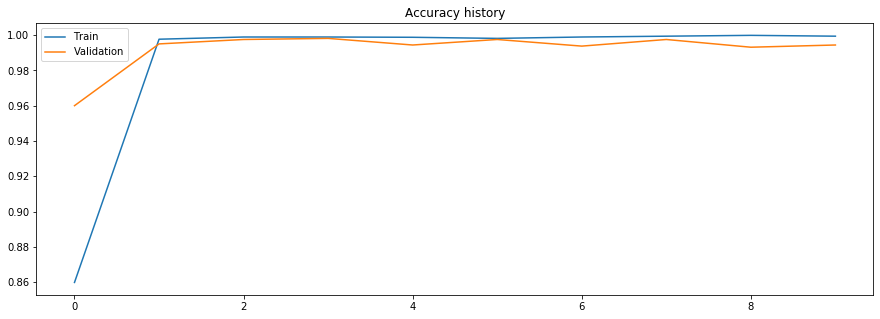

In [66]:
plt.figure(figsize=(15,5))
plt.plot(hist.history["accuracy"],label="Train")
plt.plot(hist.history["val_accuracy"],label="Validation")
plt.legend()
plt.title("Accuracy history")
plt.show()

# Part 4: Evaluation

In [79]:
predictions = model.predict(X_test_padded)

In [80]:
predictions = [1 if prediction > 0.5 else 0 for prediction in predictions]

In [81]:
def accuracy(y_true,predictions):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == predictions[i]:
            correct += 1
    accuracy = (correct / len(y_true))*100
    return accuracy

In [85]:
ac = accuracy(y_test,predictions)
print(f'Accuracy in test set = {ac}%')

Accuracy in test set = 99.75%


In [90]:
sentence_pos = "It's such a nice day, think i'll be taking Sid to Ramsgate fish and chips for lunch at Peter's fish factory and then the beach maybe"
sentence_neg = "I hated my day, it was the worst, I'm so sad."

sentence_pos, sentence_neg = preprocess_tweet(sentence_pos), preprocess_tweet(sentence_neg)

sentence_pos, sentence_neg = tweet_to_tensor(sentence_pos,word2Ind), tweet_to_tensor(sentence_neg,word2Ind)

sentence_pos = keras.preprocessing.sequence.pad_sequences([sentence_pos],padding="post",maxlen=max_length)
sentence_neg = keras.preprocessing.sequence.pad_sequences([sentence_neg],padding="post",maxlen=max_length)

sentence_pos_prob = 1 if model.predict(sentence_pos)>0.5 else 0
sentence_neg_prob = 1 if model.predict(sentence_neg)>0.5 else 0

print(f"The sentiment of the sentence_pos = {sentence_pos_prob}")
print(f"The sentiment of the sentence_neg = {sentence_neg_prob}")

The sentiment of the sentence_pos = 1
The sentiment of the sentence_neg = 0
